In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/clasificar-texto-lstm/test.csv
/kaggle/input/clasificar-texto-lstm/train.csv


In [11]:
!pip install requests

In [12]:
!pip install nltk

In [13]:
import requests
import numpy as np
import pandas as pd
import re
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split

a. Crear un código python para invocar el servicio proporcionado y leer los datos en un dataframe (Puede utilizar la libreria request)

In [14]:

train = "/content/train.csv"


In [15]:
data = pd.read_csv("/content/train.csv")


In [16]:
df = pd.DataFrame(data)

In [17]:
df

,index,titulo,categoria
0,610,"""De nada sirven los triunfos si la paz no los ...",Película y Animación
1,819,"""Hay mejores formas para uno mostrar su forma ...",Película y Animación
2,637,#LosNacionalesXSeñal - Bahía Cupica,Deportes
3,740,#LosNacionalesXSeñal - Estudiantes Utech balon...,Deportes
4,160,#LosNacionalesXSeñal - Las pruebas de triatlón...,Deportes
...,...,...,...
795,778,¿Qué harías tú? - Esto se puso salsa,Entretenimiento
796,93,¿Qué opinas sobre el machismo?,Película y Animación
797,906,¿Te cortarón los servicios?.. Tranquilo ya est...,Película y Animación
798,440,"Óscar Figueroa, con dos medallas en el Mundial...",Deportes


**La variable objetivo es predecir la columna categoria (Se debe transformar en Entretenimiento, Deportes, Película y Animación, Educación y Otros) utilizando el texto del titulo.**

Se transforman los datos de la descripción


In [18]:
i_categoria = set([i for i,v in
    zip(df["categoria"].value_counts().index, df["categoria"].value_counts().values) if v > 30 ])
df["categoria"].apply(lambda x: x if x in i_categoria else 'Otros').value_counts() # Use "categoria" instead of "categoría"


categoria
Entretenimiento         223
Deportes                189
Película y Animación    173
Educación               113
Gente y Blogs            54
Otros                    48
Name: count, dtype: int64

In [19]:
df = df.rename(columns={'categoría': 'categoria'})

**i. Utilizar todos los datos, y explorar el numero total de palabras únicas en todos los títulos de train y el numero total de repeticiones (Crear un diccionario para saber si la palabra ya fue observada antes e intentar remover tildes y poner el texto en minúsculas)**
Creamos un diccionario para almacenar la frecuencia de palabras

In [20]:
palabrasFrecuentes = {}
palabras = {}
palabrasUnicas = {}

Creamos una función para elimines algunas caracteres espacial como tildes, numeros entre otros.



In [21]:
def cambioLetras(letra):
    letra = re.sub('[áäâà]', 'a', letra.lower())
    letra = re.sub('[éëêè]', 'e', letra)
    letra = re.sub('[íïîì]', 'i', letra)
    letra = re.sub('[óöôò]', 'o', letra)
    letra = re.sub('[úüûù]', 'u', letra)
    letra = re.sub('[^a-z]', ' ', letra)
    letra = re.sub('\s+', ' ', letra)
    return letra.strip()

iteramos sobre cada título

In [22]:
for titulo in df['titulo']:
    # Se limpia el texto
    cambiotitulo = cambioLetras(titulo)
    # Se divide el título en palabras individuales
    palabras = cambiotitulo.split()
    # Se crea un conjunto (set) de palabras únicas
    palabrasUnicas = set(palabras)

    # Se convierte el conjunto nuevamente a una lista
    palabrasUnicas = list(palabrasUnicas)

    # Se cuenta la frecuencia de cada palabra
    for palabra in palabras:
        if palabra in palabrasFrecuentes:
            palabrasFrecuentes[palabra] += 1
        else:
            palabrasFrecuentes[palabra] = 1

In [23]:
numeroDePalabrasUnicas = len(palabrasFrecuentes)
numeroRepeteciones = sum(palabrasFrecuentes.values())

Resultados

In [24]:
print("Número total de palabras únicas:", numeroDePalabrasUnicas)
print("Número total de repeticiones:", numeroRepeteciones)

Número total de palabras únicas: 1604
Número total de repeticiones: 5679


Número total de palabras únicas: 5627
Número total de repeticiones: 45718

¿Cuántas palabras hay en el data set?

In [25]:
print("Número total de palabras en el dataset:", numeroRepeteciones)

Número total de palabras en el dataset: 5679


Número total de palabras en el dataset: 5679

# **Generar la Matriz**
Creamos un dataframe vacío con las palabras únicas como columnas

In [26]:
matriz = pd.DataFrame(columns=palabrasUnicas)

Se itera sobre cada título en el dataframe

In [27]:
for index, titulo in enumerate(df['titulo']):
    # Se limpia el texto
    cambiotitulo = cambioLetras(titulo)
    # Se divide el título en palabras individuales
    palabras = cambiotitulo.split()
    # Se cuenta la frecuencia de cada palabra en el título
    contarPalabras = {palabra: palabras.count(palabra) for palabra in palabrasUnicas}
    # Se convierten los resultados en un dataframe temporal
    tempDf = pd.DataFrame(contarPalabras, index=[index])
    # Se concatena el dataframe temporal con la matriz
    matriz = pd.concat([matriz, tempDf])

Asignamos los títulos

In [28]:
matriz.index = df['titulo']

Se muestra la matriz

In [29]:
print(matriz)

                                                   dia del en de ultimo  \
titulo                                                                    
"De nada sirven los triunfos si la paz no los c...   0   0  0  1      0   
"Hay mejores formas para uno mostrar su forma d...   0   0  0  1      0   
#LosNacionalesXSeñal - Bahía Cupica                  0   0  0  0      0   
#LosNacionalesXSeñal - Estudiantes Utech balonmano   0   0  0  0      0   
#LosNacionalesXSeñal - Las pruebas de triatlón ...   0   0  0  3      0   
...                                                 ..  .. .. ..    ...   
¿Qué harías tú? - Esto se puso salsa                 0   0  0  0      0   
¿Qué opinas sobre el machismo?                       0   0  0  0      0   
¿Te cortarón los servicios?.. Tranquilo ya esta...   0   0  0  1      0   
Óscar Figueroa, con dos medallas en el Mundial ...   0   0  1  2      0   
Último día de competencias del Ciclismo de Pist...   1   1  1  2      1   

                        

# **ii. Crear un gráfico de barras con las 10 palabras más comunes.**

Obtenemos las 10 palabras más comunes y sus frecuencias

In [30]:
palabrasComunes = sorted(palabrasFrecuentes.items(), key=lambda x: x[1], reverse=True)[:10]
principalesPalabras = [palabra[0] for palabra in palabrasComunes]
numeroPalbras = [palabra[1] for palabra in palabrasComunes]

Se crea el grafico de barras

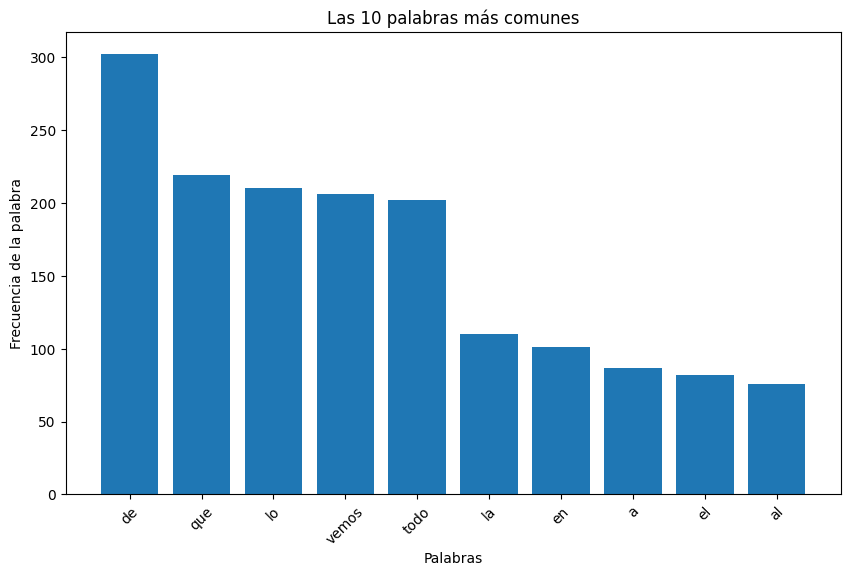

In [31]:
plt.figure(figsize=(10, 6))
plt.bar(principalesPalabras, numeroPalbras)
plt.xlabel('Palabras')
plt.ylabel('Frecuencia de la palabra')
plt.title('Las 10 palabras más comunes')
plt.xticks(rotation=45)
plt.show()

**¿Son utiles?**
Cuando se analizan las palabras más comunes en los títulos, a menudo se utilizan gráficos de barras para mostrar las frecuencias de las palabras de manera visual y rápida. Sin embargo, hay situaciones en las que un gráfico de barras puede no ser la opción más adecuada, especialmente cuando hay muchas palabras únicas y las frecuencias varían considerablemente.

Normalmente las palabras más comunes son llamadas stop words. Y corresponden a los artículos o preposiciones. Generar nuevamente los gráficos. Y una matriz de correlación utilizando dummy variables para las variables objetivo “categoria”.
Creamos los dummy para la variable objetivo "Categoria"

In [32]:
dummy_categoria = pd.get_dummies(df['categoria'])

Se botienen las 10 palabras más comunes y sus frecuencias

In [33]:
palabrasComunes = sorted(palabrasFrecuentes.items(), key=lambda x: x[1], reverse=True)[:10]
principalesPalabras = [palabra[0] for palabra in palabrasComunes]
numeroPalbras = [palabra[1] for palabra in palabrasComunes]

Se crea el grafico de barras

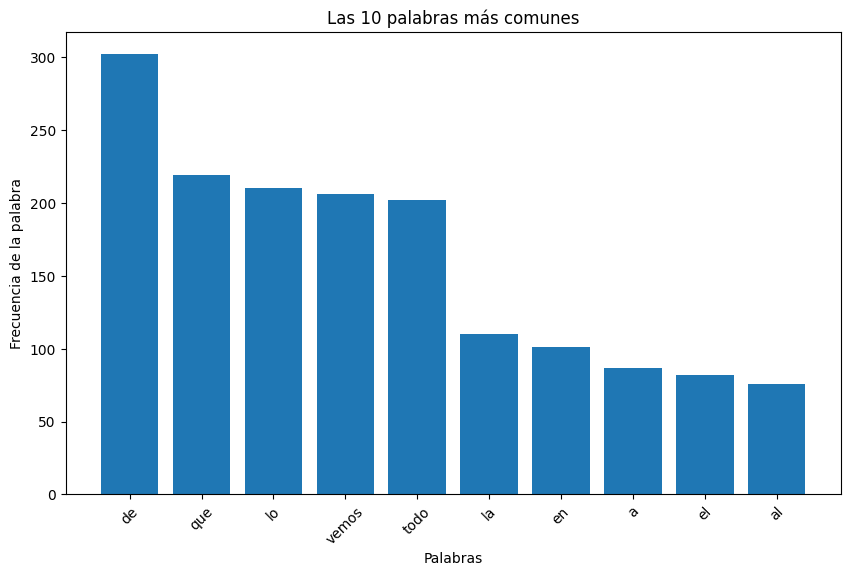

In [34]:
plt.figure(figsize=(10, 6))
plt.bar(principalesPalabras, numeroPalbras)
plt.xlabel('Palabras')
plt.ylabel('Frecuencia de la palabra')
plt.title('Las 10 palabras más comunes')
plt.xticks(rotation=45)
plt.show()

Creamos la matriz de correlación con los dummy variables

Text(0.5, 1.0, 'Matriz de correlación')

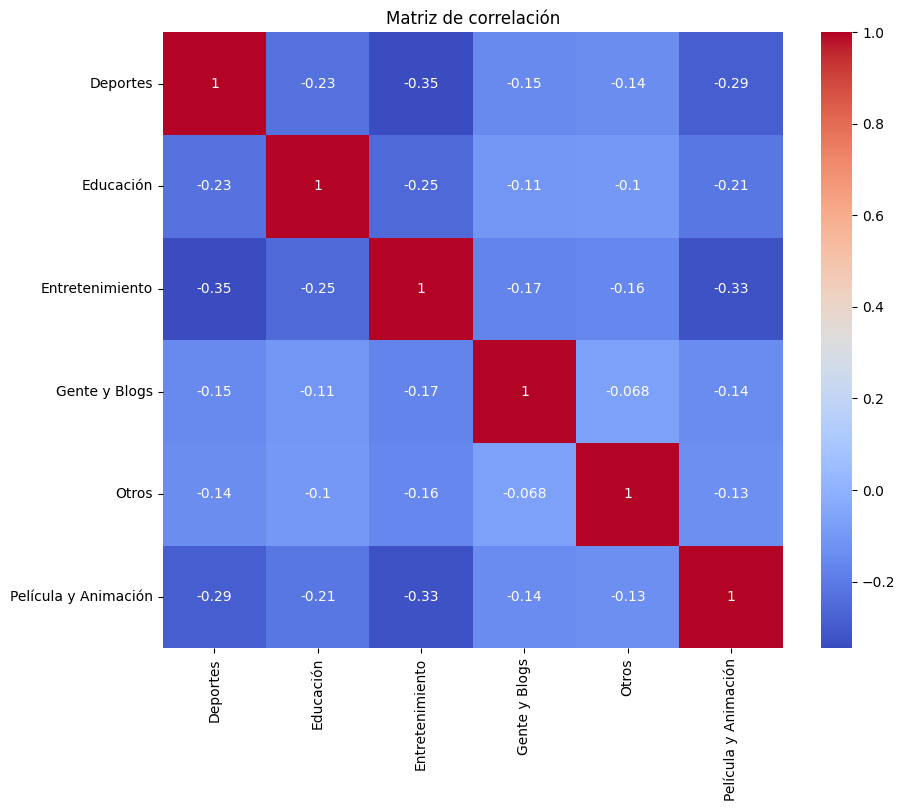

In [35]:
correlacion_matriz = dummy_categoria.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlacion_matriz, annot=True, cmap='coolwarm')
plt.title('Matriz de correlación')

También generar la matriz nueva eliminando los stopwords y dividimos por el numero total de palabras en cada título. Esta matriz se llama TF (Term Frequency

In [36]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Obtenemos los stopwords en español

In [37]:
stopwords = stopwords.words('spanish')

Eliminamos los stopwords de las palabras únicas

In [38]:
palabrasUnicas = [palabra for palabra in palabrasUnicas if palabra not in stopwords]

Creamos un dataframe vacío con las palabras únicas en columnas

In [39]:
matriz = pd.DataFrame(columns=palabrasUnicas)

Iteramos en cada título

In [40]:
for index, titulo in enumerate(df['titulo']):
    # Se limpia el texto
    cambiotitulo = cambioLetras(titulo)
    # Se divide el título en palabras individuales
    palabras = cambiotitulo.split()
    # Se eliminan los stopwords de las palabras
    palabras = [palabra for palabra in palabras if palabra not in stopwords]

    if len(palabras) > 0:
        totalPalabras = len(palabras)
        # Se calcula la frecuencia de cada palabra en el título y dividir por el número total de palabras
        contarPalabras = {palabra: palabras.count(palabra) / totalPalabras for palabra in palabrasUnicas}
        # Se convierten los resultados en un dataframe temporal
        tempDf = pd.DataFrame(contarPalabras, index=[index])
        # Se concatena el dataframe temporal con la matriz
        matriz = pd.concat([matriz, tempDf])

In [41]:
df = df.drop_duplicates(subset='titulo')  # Eliminar duplicados en el DataFrame df
df.reset_index(drop=True, inplace=True)  # Restablecer los índices del DataFrame df

# Volver a generar el DataFrame matrix con los datos actualizados de df
matriz = pd.DataFrame(columns=palabrasUnicas)
for index, titulo in enumerate(df['titulo']):
    cambiotitulo = cambioLetras(titulo)
    palabras = cambiotitulo.split()
    contarPalabras = {palabra: palabras.count(palabra) / len(palabras) if len(palabras) != 0 else 0 for palabra in palabrasUnicas}
    tempDf = pd.DataFrame(contarPalabras, index=[index])
    matriz = pd.concat([matriz, tempDf])

In [42]:
matriz.index = df['titulo']

In [43]:

print(matriz)

                                                         dia    ultimo  \
titulo                                                                   
"De nada sirven los triunfos si la paz no los c...  0.000000  0.000000   
"Hay mejores formas para uno mostrar su forma d...  0.000000  0.000000   
#LosNacionalesXSeñal - Bahía Cupica                 0.000000  0.000000   
#LosNacionalesXSeñal - Estudiantes Utech balonmano  0.000000  0.000000   
#LosNacionalesXSeñal - Las pruebas de triatlón ...  0.000000  0.000000   
...                                                      ...       ...   
¿Qué harías tú? - Esto se puso salsa                0.000000  0.000000   
¿Qué opinas sobre el machismo?                      0.000000  0.000000   
¿Te cortarón los servicios?.. Tranquilo ya esta...  0.000000  0.000000   
Óscar Figueroa, con dos medallas en el Mundial ...  0.000000  0.000000   
Último día de competencias del Ciclismo de Pist...  0.090909  0.090909   

                                     

# Nueva sección
iii. Ahora vamos a crear un vector contando el numero de titulos que tiene cada palabra. Este vector tiene “n” elementos y el valor es el número de títulos que tiene la palabra.
Creamos un vector para contar el número de títulos que contienen cada palabra

In [44]:

numeroTitulos = []

In [45]:
for palabra in palabrasUnicas:
    # Contar el número de títulos que contienen la palabra
    contar = sum(matriz[palabra] > 0)
    numeroTitulos.append(contar)

Vector del conteo

In [46]:
print(numeroTitulos)

[5, 2, 14, 2, 3, 2, 1]


# Por último vamos a transformar el numero calculando el log(Total de documentos/ (Numero de documentos con la Palabra i + 1) ). El +1 es para q no quede el numero indeterminado cuando algún valor es “0”, el vector es llamado IDF(Inverse Document Frequency)
Creamos una matriz vacía con las palabras únicas como columnas

In [47]:

idfMatriz = np.zeros((len(df), len(palabrasUnicas)))

In [48]:
for i, palabra in enumerate(palabrasUnicas):
    # Calcular el IDF para la palabra
    idf = np.log(len(df) / (numeroTitulos[i] + 1))
    # Asignar el IDF a la columna correspondiente en la matriz
    idfMatriz[:, i] = idf

convertimos la matriz en un DataFrame de pandas con los títulos como índices



In [50]:
idfDf = pd.DataFrame(idfMatriz, index=df['titulo'], columns=palabrasUnicas)


In [51]:
print(idfDf)

                                                         dia    ultimo  \
titulo                                                                   
"De nada sirven los triunfos si la paz no los c...  4.885324  5.578471   
"Hay mejores formas para uno mostrar su forma d...  4.885324  5.578471   
#LosNacionalesXSeñal - Bahía Cupica                 4.885324  5.578471   
#LosNacionalesXSeñal - Estudiantes Utech balonmano  4.885324  5.578471   
#LosNacionalesXSeñal - Las pruebas de triatlón ...  4.885324  5.578471   
...                                                      ...       ...   
¿Qué harías tú? - Esto se puso salsa                4.885324  5.578471   
¿Qué opinas sobre el machismo?                      4.885324  5.578471   
¿Te cortarón los servicios?.. Tranquilo ya esta...  4.885324  5.578471   
Óscar Figueroa, con dos medallas en el Mundial ...  4.885324  5.578471   
Último día de competencias del Ciclismo de Pist...  4.885324  5.578471   

                                     

iv. Ahora vamos a multiplicar el vector TF (La matriz) * IDF (Vector transpuesto), El resultado es una matriz de m títulos por n palabras. Y dividir el dataset en test y train. En producción se debería dividir los datos antes de calcular el TF-IDF , y para calcular la matriz TFIDF en testing es necesario calcular la frecuencia de las palabras en testing utilizando el orden y las palabras en training y utilizar el IDF de training, pero no es necesario para esta tarea.

Eliminanos los valores que estan nulos

In [52]:
df = df.dropna(subset=['titulo'])


Reindexar el dataframe después de eliminar los valores nulos

In [53]:

df = df.reset_index(drop=True)

dividemos los datos en entrenamiento y prueba

In [54]:
X_train, X_test, y_train, y_test = train_test_split(df['titulo'], df['categoria'], test_size=0.2, random_state=42)


In [82]:
df.to_csv('train_2.csv', index=False)

creamos el vectorizador TF-IDF

In [55]:
tfidfVectorizer = TfidfVectorizer(stop_words=None)

Transformamos los datos de entrenamiento

In [56]:
tfidfTrain = tfidfVectorizer.fit_transform(X_train)


Transformamos los datos de prueba

In [57]:
tfidfTest = tfidfVectorizer.transform(X_test)

In [58]:

print("Dimensiones de la matriz TF-IDF de entrenamiento:", tfidfTrain.shape)
print("Dimensiones de la matriz TF-IDF de prueba:", tfidfTest.shape)

Dimensiones de la matriz TF-IDF de entrenamiento: (635, 1557)
Dimensiones de la matriz TF-IDF de prueba: (159, 1557)


v. Utilizando la matriz vamos a entrenar 3 modelos, una regresión logística, un random forest y un GBM. Vamos a crear una matriz de confusión y vamos a comparar los 3 modelos. ¿Cuál es el mejor modelo?, incluir métricas como accuracy, precision y recall para cada modelo

In [59]:
scaler = StandardScaler(with_mean=False)
tfidf_train_scaled = scaler.fit_transform(tfidfTrain)
tfidf_test_scaled = scaler.transform(tfidfTest)

Modelo de regrecion logistica

In [60]:
regrecionLogistica = LogisticRegression(max_iter=7000)
regrecionLogistica.fit(tfidfTrain, y_train)
prediccionRegrecion = regrecionLogistica.predict(tfidfTest)

Generamos el accuracy el precision y el recall

In [61]:
regrecionLogisticaAccuracy = accuracy_score(y_test, prediccionRegrecion)
regrecionLogisticaprecision = precision_score(y_test, prediccionRegrecion, average='weighted', zero_division=1)
regrecionLogisticaRecall = recall_score(y_test, prediccionRegrecion, average='weighted')

Creamos la matriz de confusion pa el modelo de regresion

In [62]:

regrecionLogisticaMatriz = confusion_matrix(y_test, prediccionRegrecion)

In [63]:
print("Regresión Logística")
print("Accuracy:", regrecionLogisticaAccuracy)
print("Precision:", regrecionLogisticaprecision)
print("Recall: ", regrecionLogisticaRecall)
print("Matriz de Confusión")
print(regrecionLogisticaMatriz)

Regresión Logística
Accuracy: 0.6477987421383647
Precision: 0.638127252636036
Recall:  0.6477987421383647
Matriz de Confusión
[[33  0  0  0  0  2]
 [ 2  8  9  0  0  2]
 [ 2  0 40  0  0  3]
 [ 3  1  5  1  0  2]
 [ 2  2  2  0  3  2]
 [ 3  5  7  2  0 18]]


Modelo random forest

In [64]:
randomForest = RandomForestClassifier(min_samples_split=50, min_samples_leaf=1)


In [65]:
randomForest.fit(tfidf_train_scaled, y_train)


RandomForestClassifier(min_samples_split=50)

In [70]:
randomForestPredcion = randomForest.predict(tfidf_test_scaled)


In [71]:
randomForestAccuracy = accuracy_score(y_test, randomForestPredcion)
randomForestPrecision = precision_score(y_test, randomForestPredcion, average='weighted', zero_division=1)
randomForestRecall = recall_score(y_test, randomForestPredcion, average='weighted', zero_division=1)


Creamos la matriz de confusion pa el modelo de random forest

In [72]:

randomForestMatriz = confusion_matrix(y_test, randomForestPredcion)

In [73]:
print("Random Forest")
print("Accuracy:", randomForestAccuracy)
print("Precision:", randomForestPrecision)
print("Recall:", randomForestRecall)
print("Matriz de Confusión")
print(randomForestMatriz)

Random Forest
Accuracy: 0.6477987421383647
Precision: 0.6489628837872169
Recall: 0.6477987421383647
Matriz de Confusión
[[33  1  0  0  0  1]
 [ 1  8  9  1  0  2]
 [ 1  0 39  0  0  5]
 [ 1  2  4  3  0  2]
 [ 2  2  1  1  3  2]
 [ 2  7  7  2  0 17]]


Modelo de GBM

In [74]:
gbm = GradientBoostingClassifier(min_samples_split=50, min_samples_leaf=1, learning_rate=0.4)


In [75]:
gbm.fit(tfidf_train_scaled, y_train)


GradientBoostingClassifier(learning_rate=0.4, min_samples_split=50)

Realizamos la predicion en los datos de prueba

In [76]:
gbmPredicion = gbm.predict(tfidf_test_scaled)

In [77]:
gbmAccuracy = accuracy_score(y_test, gbmPredicion)
gbmPrecision = precision_score(y_test, gbmPredicion, average='weighted', zero_division=1)
gbmRecall = recall_score(y_test, gbmPredicion, average='weighted', zero_division=1)

Creamos la matriz de confusion pa el modelo de GBM

In [78]:
gbmMatriz = confusion_matrix(y_test, gbmPredicion)

In [79]:
print("GBM")
print("Accuracy:", gbmAccuracy)
print("Precision:", gbmPrecision)
print("Recall:", gbmRecall)
print("Matriz de Confusión")
print(gbmMatriz)

GBM
Accuracy: 0.6226415094339622
Precision: 0.647411773210694
Recall: 0.6226415094339622
Matriz de Confusión
[[28  2  2  1  0  2]
 [ 1 10  4  4  0  2]
 [ 0  0 36  4  0  5]
 [ 0  1  4  4  0  3]
 [ 1  2  3  1  4  0]
 [ 4  3  9  2  0 17]]


**¿Cuál es el mejor modelo?**


Exactitud (Accuracy):

Tanto el Random Forest como la Regresión Logística tienen la misma exactitud (0.648), que es mayor que la del GBM (0.623).
Precisión (Precision):

Random Forest tiene la mayor precisión (0.649), seguido de GBM (0.647) y luego la Regresión Logística (0.638).
Recuperación (Recall):

Random Forest y la Regresión Logística tienen la misma recuperación (0.648), mientras que GBM tiene una menor (0.623).
Matriz de Confusión:

La matriz de confusión del Random Forest muestra un buen rendimiento en la mayoría de las clases, con una cantidad relativamente baja de falsos negativos y falsos positivos en comparación con los otros modelos.
La Regresión Logística tiene un rendimiento similar al de Random Forest en términos de falsos positivos y negativos.
GBM tiene más falsos positivos y negativos, especialmente en algunas clases, lo que sugiere un rendimiento inferior en la clasificación de ciertas categorías.

Conclusión

Considerando la precisión, la recuperación y la matriz de confusión, Random Forest es el mejor modelo entre los expuestos. Aunque la Regresión Logística tiene la misma exactitud y recuperación, Random Forest tiene una ligera ventaja en precisión y un mejor balance en la matriz de confusión, lo que indica un rendimiento más consistente en la clasificación de las diferentes categorías. GBM, aunque competitivo, tiene un rendimiento inferior en varios aspectos clave.

Por lo tanto, Random Forest es el modelo recomendado en este caso debido a su mayor precisión y mejor desempeño general en la matriz de confusión.

In [84]:
# prompt: llamar el /content/test.csv hacer la prediccion guardar el index y la categoria donde el la categoria es la predicion del modelo, recuerda hacer todo el pre procesamoento

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Cargar el conjunto de datos de prueba
test_data = pd.read_csv("/content/test.csv")



tfidfTest = tfidfVectorizer.transform(test_data['titulo'])
tfidf_test_scaled = scaler.transform(tfidfTest)
# Realizar predicciones en el conjunto de datos de prueba
prediccionRegrecion = regrecionLogistica.predict(tfidf_test_scaled)
prediccionRandomForest = randomForest.predict(tfidf_test_scaled)
prediccionGBM = gbm.predict(tfidf_test_scaled)

# Crear un dataframe con los resultados
resultadosRegresionLogistica = pd.DataFrame({'ID': test_data['index'], 'categoria': prediccionRegrecion})
resultadosForest = pd.DataFrame({'ID': test_data['index'], 'categoria': prediccionRandomForest})
resultadosGBM = pd.DataFrame({'ID': test_data['index'], 'categoria': prediccionGBM})

resultadosRegresionLogistica.to_csv('resultadosRegresionLogistica.csv', index=False)
resultadosForest.to_csv('resultadosForest.csv', index=False)
resultadosGBM.to_csv('resultadosGBM.csv', index=False)
